### Homework 5: Question search engine

Remeber week01 where you used GloVe embeddings to find related questions? That was.. cute, but far from state of the art. It's time to really solve this task using context-aware embeddings.

__Warning:__ this task assumes you have seen `seminar.ipynb`!

In [1]:
%pip install --upgrade transformers datasets accelerate deepspeed evaluate
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
import datasets
from tqdm import tqdm
from multiprocessing import cpu_count
import warnings
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'true'  # чтоб избежать warning
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.5 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 90.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.6/503.6 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.9/374.9 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.3/563.3 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 39.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 76.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━

### Load data and model

In [2]:
qqp = datasets.load_dataset('SetFit/qqp')
print('\n')
print("Sample[0]:", qqp['train'][0])
print("Sample[3]:", qqp['train'][3])

README.md:   0%|          | 0.00/313 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.jsonl:   0%|          | 0.00/70.8M [00:00<?, ?B/s]

validation.jsonl: 0.00B [00:00, ?B/s]

test.jsonl:   0%|          | 0.00/76.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/363846 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/40430 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/390965 [00:00<?, ? examples/s]



Sample[0]: {'text1': 'How is the life of a math student? Could you describe your own experiences?', 'text2': 'Which level of prepration is enough for the exam jlpt5?', 'label': 0, 'idx': 0, 'label_text': 'not duplicate'}
Sample[3]: {'text1': 'What can one do after MBBS?', 'text2': 'What do i do after my MBBS ?', 'label': 1, 'idx': 3, 'label_text': 'duplicate'}


In [3]:
model_name = "gchhablani/bert-base-cased-finetuned-qqp"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/890 [00:00<?, ?B/s]

2025-09-27 06:02:17.442249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758952937.661706      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758952937.727416      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

### Tokenize the data

In [4]:
MAX_LENGTH = 128
def preprocess_function(examples):
    result = tokenizer(
        examples['text1'], examples['text2'],
        padding='max_length', max_length=MAX_LENGTH, truncation=True
    )
    result['label'] = examples['label']
    return result

qqp_preprocessed = qqp.map(preprocess_function, batched=True)

Map:   0%|          | 0/363846 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Map:   0%|          | 0/40430 [00:00<?, ? examples/s]

Map:   0%|          | 0/390965 [00:00<?, ? examples/s]

In [5]:
print(repr(qqp_preprocessed['train'][0]['input_ids'])[:100], "...")

[101, 1731, 1110, 1103, 1297, 1104, 170, 12523, 2377, 136, 7426, 1128, 5594, 1240, 1319, 5758, 136,  ...


### Task 1: evaluation (1 point)

We randomly chose a model trained on QQP - but is it any good?

One way to measure this is with validation accuracy - which is what you will implement next.

Here's the interface to help you do that:

In [6]:
val_set = qqp_preprocessed['validation']
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=1, shuffle=False, collate_fn=transformers.default_data_collator
)

In [7]:
for batch in val_loader:
     break  # here be your training code
print("Sample batch:", batch)

with torch.no_grad():
  predicted = model(
      input_ids=batch['input_ids'],
      attention_mask=batch['attention_mask'],
      token_type_ids=batch['token_type_ids']
  )

print('\nPrediction (probs):', torch.softmax(predicted.logits, dim=1).data.numpy())

Sample batch: {'labels': tensor([0]), 'idx': tensor([0]), 'input_ids': tensor([[  101,  2009,  1132,  2170,   118,  4038,  1177,  2712,   136,   102,
          2009,  1132,  1117, 10224,  4724,  1177,  2712,   136,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,   

__Your task__ is to measure the validation accuracy of your model.
Doing so naively may take several hours. Please make sure you use the following optimizations:

- run the model on GPU with no_grad
- using batch size larger than 1
- use optimize data loader with num_workers > 1
- (optional) use [mixed precision](https://pytorch.org/docs/stable/notes/amp_examples.html)


In [8]:
num_workers = cpu_count()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=8, shuffle=False, collate_fn=transformers.default_data_collator,
    num_workers=num_workers
)
model = model.to(device)

In [9]:
labels = []
preds = []
with torch.no_grad():
    for batch in tqdm(val_loader):
        labels.extend(batch['labels'])
        predicted = model(
            input_ids=batch['input_ids'].to(device),
            attention_mask=batch['attention_mask'].to(device),
            token_type_ids=batch['token_type_ids'].to(device)
        )
        preds.extend(predicted.logits.argmax(axis=1).cpu())


100%|██████████| 5054/5054 [05:01<00:00, 16.74it/s]


In [10]:
labels = torch.tensor(labels)
preds = torch.tensor(preds)
accuracy = (labels == preds).sum().item() / len(labels)
assert 0.9 < accuracy < 0.91

In [11]:
accuracy

0.9083848627256987

### Task 2: train the model (4 points)

For this task, you have two options:

__Option A:__ fine-tune your own model. You are free to choose any model __except for the original BERT.__ We recommend [DeBERTa-v3](https://huggingface.co/microsoft/deberta-v3-base). Better yet, choose the best model based on public benchmarks (e.g. [GLUE](https://gluebenchmark.com/)).

You can write the training code manually or use transformers.Trainer (see [this example](https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification)). Please make sure that your model's accuracy is at least __comparable__ with the above example for BERT.


__Option B:__ compare at least 3 pre-finetuned models (in addition to the above BERT model). For each model, report (1) its accuracy, (2) its speed, measured in samples per second in your hardware setup and (3) its size in megabytes. Please take care to compare models in equal setting, e.g. same CPU / GPU. Compile your results into a table and write a short (~half-page on top of a table) report, summarizing your findings.

In [12]:
model_name = 'microsoft/deberta-v3-base'
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
deberta_model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
MAX_LENGTH = 128
def preprocess_function(examples):
    result = tokenizer(
        examples['text1'], examples['text2'],
        padding='max_length', max_length=MAX_LENGTH, truncation=True
    )
    result['label'] = examples['label']
    return result

qqp_preprocessed = qqp.map(preprocess_function, batched=True)

Map:   0%|          | 0/363846 [00:00<?, ? examples/s]

Map:   0%|          | 0/40430 [00:00<?, ? examples/s]

Map:   0%|          | 0/390965 [00:00<?, ? examples/s]

In [14]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

val_set = qqp_preprocessed['validation']
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=8, shuffle=False, collate_fn=transformers.default_data_collator,
    num_workers=num_workers
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deberta_model = deberta_model.to(device)
predictions = torch.tensor(data=[], dtype=torch.int32).to(device)
labels = torch.tensor(data=[], dtype=torch.int32)

with torch.no_grad():
    for batch in tqdm(val_loader):
        labels = torch.cat((labels, batch['labels']), dim=0)
        predicted = deberta_model(
            input_ids=batch['input_ids'].to(device),
            attention_mask=batch['attention_mask'].to(device),
            token_type_ids=batch['token_type_ids'].to(device)
        )
        predictions = torch.cat((predictions, torch.argmax(predicted.logits, dim=1)), dim=0)
        
accuracy = accuracy_score(labels, predictions.cpu())
accuracy

100%|██████████| 5054/5054 [06:19<00:00, 13.32it/s]


0.36816720257234725

In [15]:
qqp_preprocessed

DatasetDict({
    train: Dataset({
        features: ['text1', 'text2', 'label', 'idx', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 363846
    })
    validation: Dataset({
        features: ['text1', 'text2', 'label', 'idx', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 40430
    })
    test: Dataset({
        features: ['text1', 'text2', 'label', 'idx', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 390965
    })
})

In [16]:
qqp_preprocessed = qqp_preprocessed.rename_column('label', 'labels')
qqp_preprocessed.set_format('torch', columns=['input_ids', 'attention_mask', 'labels', 'token_type_ids'])

In [17]:
from torch.utils.data import DataLoader

batch_size = 16

small_train_dataset = qqp_preprocessed["train"].shuffle(seed=42).select(range(60000))
small_val_dataset = qqp_preprocessed["validation"].shuffle(seed=42).select(range(15000))

train_loader = DataLoader(small_train_dataset, shuffle=True, batch_size=batch_size, 
                          collate_fn=transformers.default_data_collator, num_workers=num_workers)
val_loader = DataLoader(small_val_dataset, batch_size=batch_size, 
                        collate_fn=transformers.default_data_collator, num_workers=num_workers)

In [18]:
deberta_model

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [19]:
deberta_model.deberta.embeddings.requires_grad = False
deberta_model.deberta.encoder.layer.requires_grad = False

In [20]:
import matplotlib.pyplot as plt

def plot_history(train_loss, test_loss, train_acc, test_acc):
    plt.figure(figsize=(15, 9))
    plt.subplot(1, 2, 1)
    x = range(1, len(train_loss) + 1)
    plt.plot(x, train_loss, '-bo', label='train loss')
    plt.plot(x, test_loss, '-ro', label='val loss')
    plt.legend(loc='best')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.grid()
    
    plt.subplot(1, 2, 2)
    x = range(1, len(train_acc) + 1)
    plt.plot(x, train_acc, '-bo', label='train acc')
    plt.plot(x, test_acc, '-ro', label='val acc')
    plt.legend(loc='best')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.grid()
    
    plt.show()

In [21]:
from torch.optim import AdamW
from transformers import get_scheduler

optimizer = AdamW(deberta_model.parameters(), lr=1e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

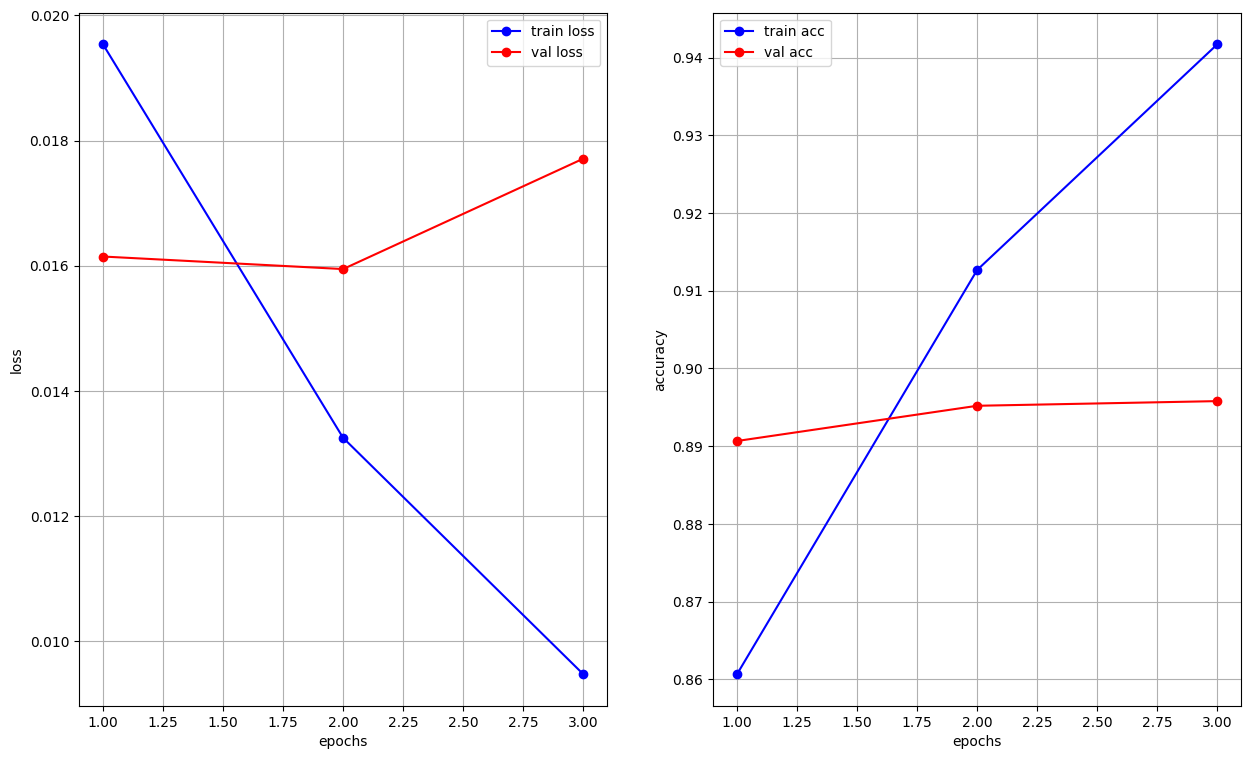

<All keys matched successfully>

In [22]:
# from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from IPython.display import clear_output
import copy
from tqdm import tqdm


train_accuracy = []
train_losses = []
val_accuracy = []
val_losses = []

best_state_dict = None
best_val_loss = None
train_len = len(train_loader)
val_len = len(val_loader)

for epoch in range(num_epochs):
    deberta_model.train()
    print("Epoch", epoch + 1)
    train_labels = []
    train_predictions = []
    train_loss = 0
    for batch in tqdm(train_loader):
        train_labels.extend(batch['labels'].cpu().detach().numpy())
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = deberta_model(**batch)
        loss = outputs.loss
        loss.backward()

        train_loss += outputs.loss
        logits = outputs.logits
        train_predictions.extend(torch.argmax(logits, dim=-1).cpu().detach().numpy())

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    train_accuracy.append(accuracy_score(train_labels, train_predictions))
    train_losses.append(train_loss.cpu().detach().numpy() / train_len / batch_size)
            
    deberta_model.eval()
    val_labels = []
    val_predictions = []
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            val_labels.extend(batch['labels'].cpu().detach().numpy())
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = deberta_model(**batch)      
            val_loss += outputs.loss
            logits = outputs.logits
            val_predictions.extend(torch.argmax(logits, dim=-1).cpu().detach().numpy())

    val_accuracy.append(accuracy_score(val_labels, val_predictions))
    val_losses.append(val_loss.cpu().detach().numpy() / val_len / batch_size)

    if best_val_loss is None or val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        best_state_dict = copy.deepcopy(deberta_model.state_dict())

    clear_output()
    plot_history(
        train_losses, val_losses, 
        train_accuracy, val_accuracy
    )

deberta_model.load_state_dict(best_state_dict)
                

In [33]:
torch.save(deberta_model.state_dict(), 'deberta_qqp.pt')

In [25]:
# измерим accuracy после обучения
val_set = qqp_preprocessed['validation']
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=8, shuffle=False, collate_fn=transformers.default_data_collator,
    num_workers=num_workers
)
predictions = torch.tensor(data=[], dtype=torch.int32).to(device)
labels = torch.tensor(data=[], dtype=torch.int32)

with torch.no_grad():
    for batch in tqdm(val_loader):
        labels = torch.cat((labels, batch['labels']), dim=0)
        predicted = deberta_model(
            input_ids=batch['input_ids'].to(device),
            attention_mask=batch['attention_mask'].to(device),
            token_type_ids=batch['token_type_ids'].to(device)
        )
        predictions = torch.cat((predictions, torch.argmax(predicted.logits, dim=1)), dim=0)
        
accuracy = accuracy_score(labels, predictions.cpu())
accuracy

100%|██████████| 5054/5054 [06:29<00:00, 12.99it/s]


0.8931486519910957

Разница < 0.01

In [26]:
import kagglehub

kagglehub.login()

# Replace with path to directory containing model files.
LOCAL_MODEL_DIR = '/kaggle/working/deberta_qqp.pt'

MODEL_SLUG = 'deberta_qqp.pt' # Replace with model slug.

# Learn more about naming model variations at
# https://www.kaggle.com/docs/models#name-model.
VARIATION_SLUG = 'default' # Replace with variation slug.

kagglehub.model_upload(
  handle = f"vesselchakk/{MODEL_SLUG}/pyTorch/{VARIATION_SLUG}",
  local_model_dir = LOCAL_MODEL_DIR,
  version_notes = '2025-09-27')

Uploading Model https://www.kaggle.com/models/vesselchakk/deberta_qqp.pt/pyTorch/default ...
Model 'deberta_qqp.pt' does not exist or access is forbidden for user 'vesselchakk'. Creating or handling Model...
Model 'deberta_qqp.pt' Created.
Starting upload for file /kaggle/working/deberta_qqp.pt


Uploading: 100%|██████████| 738M/738M [00:06<00:00, 120MB/s] 

Upload successful: /kaggle/working/deberta_qqp.pt (704MB)


Your model instance has been created.
Files are being processed...
See at: https://www.kaggle.com/models/vesselchakk/deberta_qqp.pt/pyTorch/default


### Task 3: try the full pipeline (1 point)

Finally, it is time to use your model to find duplicate questions.
Please implement a function that takes a question and finds top-5 potential duplicates in the training set. For now, it is fine if your function is slow, as long as it yields correct results.

Showcase how your function works with at least 5 examples.

In [34]:
# Model class must be defined somewhere
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
model.load_state_dict(torch.load(LOCAL_MODEL_DIR, weights_only=True))
model.eval()

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [45]:
qqp['train'][:10]['text1']

['How is the life of a math student? Could you describe your own experiences?',
 'How do I control my horny emotions?',
 'What causes stool color to change to yellow?',
 'What can one do after MBBS?',
 'Where can I find a power outlet for my laptop at Melbourne Airport?',
 "How not to feel guilty since I am Muslim and I'm conscious we won't have sex together?",
 'How is air traffic controlled?',
 'What is the best self help book you have read? Why? How did it change your life?',
 "Can I enter University of Melbourne if I couldn't achieve the guaranteed marks in Trinity College Foundation?",
 'Do you need a passport to go to Jamaica from the United States?']

In [47]:
# подсчитаем эмбеддинги предварительно, чтоб не считать при каждом вызове функции
train_embeddings = []
with torch.no_grad():
    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        output = model(output_hidden_states=True, **batch)
        train_embeddings.extend(output.hidden_states[-1][:, 0, :].cpu())

train_embeddings = torch.stack(train_embeddings)
print(train_embeddings.size())   

100%|██████████| 3750/3750 [09:36<00:00,  6.51it/s]


torch.Size([60000, 768])


In [61]:
import numpy as np

def get_tokens(text):
    return tokenizer(text, padding='max_length', return_tensors='pt',
                     max_length=MAX_LENGTH, truncation=True)

def get_top_k_possible_duplicates(question: str, k: int = 5):
    tokens = get_tokens(question)
    tokens = {k: torch.tensor(v).to(device) for k, v in tokens.items()}
    with torch.no_grad():
        outp = model(output_hidden_states=True, **tokens)
    emb = outp.hidden_states[-1][:, 0, :]

    similarities = F.cosine_similarity(train_embeddings, emb)
    values, indices = torch.topk(similarities, k)
    return values, train_texts[indices.cpu().numpy()]

train_texts = np.array(qqp["train"].shuffle(seed=42).select(range(60000))[:]["text1"])
train_embeddings = train_embeddings.to(device)

In [62]:
%%time
for question in qqp['validation'][:10]['text1']:
    print(question)
    probas, answers = get_top_k_possible_duplicates(question)
    for p, a in zip(probas, answers):
        print(f"Prob: {p.item():.3f}, answer: {a}.")
    print()

Why are African-Americans so beautiful?
Prob: 0.996, answer: What are vessels in terms of religion?.
Prob: 0.996, answer: Is there such security reliability on earth?.
Prob: 0.995, answer: What objections would you raise to having your email hosted in Office365?.
Prob: 0.995, answer: What are the best questions to ask a girl while chatting?.
Prob: 0.995, answer: How can I download private videos on Pornhub?.

I want to pursue PhD in Computer Science about social network,what is the open problem in social networks?
Prob: 0.980, answer: Is the 2016 MacBook Pro with Touch Bar a worthy buy?.
Prob: 0.978, answer: India how many states?.
Prob: 0.978, answer: How can I change my email, when it says it isn't available?.
Prob: 0.977, answer: How will the scrapping of Rs 500 and Rs 1000 notes help in reducing black money and corruption?.
Prob: 0.977, answer: How can I get rid of people stressing?.

Is there a reason why we should travel alone?
Prob: 0.995, answer: How do I create value?.
Prob: 0

In [95]:
from typing import List

def get_top_k_possible_duplicates_batched(questions: List[str], k: int = 5):
    tokens = get_tokens(questions)
    tokens = {k: torch.tensor(v).to(device) for k, v in tokens.items()}
    with torch.no_grad():
        outp = model(output_hidden_states=True, **tokens)
    emb = outp.hidden_states[-1][:, 0, :]

    similarities = F.cosine_similarity(train_embeddings, emb.unsqueeze(1), dim=-1)
    values, indices = torch.topk(similarities, k)
    return values.cpu(), train_texts[indices.cpu().numpy()]

In [96]:
%%time
questions = qqp['validation'][:10]['text1']
probas, answers = get_top_k_possible_duplicates_batched(questions)
for q, proba, answer, in zip(questions, probas, answers):
    print(question)
    for p, a in zip(proba, answer):
        print(f"Prob: {p.item():.3f}, answer: {a}.")
    print()

Why should I crack Jee?
Prob: 0.996, answer: What are vessels in terms of religion?.
Prob: 0.996, answer: Is there such security reliability on earth?.
Prob: 0.995, answer: What objections would you raise to having your email hosted in Office365?.
Prob: 0.995, answer: What are the best questions to ask a girl while chatting?.
Prob: 0.995, answer: How can I download private videos on Pornhub?.

Why should I crack Jee?
Prob: 0.980, answer: Is the 2016 MacBook Pro with Touch Bar a worthy buy?.
Prob: 0.978, answer: India how many states?.
Prob: 0.978, answer: How can I change my email, when it says it isn't available?.
Prob: 0.977, answer: How will the scrapping of Rs 500 and Rs 1000 notes help in reducing black money and corruption?.
Prob: 0.977, answer: How can I get rid of people stressing?.

Why should I crack Jee?
Prob: 0.995, answer: How do I create value?.
Prob: 0.995, answer: Should I find a new piano teacher to replace my current one?.
Prob: 0.995, answer: How do Jesus convince hi

In batch mode, the same thing happens **1.5** times faster.

1. I have finetuned DeBERTa-v3-base for the task of recognizing duplicate questions.
   
2. I wrote functions to search for the top 5 potential duplicates of the iterative and batch question.